# DATA2001 Assingment 3

## Data Preparation

In [665]:
import pandas as pd
import numpy as np

# Read the data
df = pd.read_csv("amzn.us.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Display the first 5 rows
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [666]:
print(type(df['Date'][2])) 

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


**Exogenous Data: VIX Index**

"Volatility Index, a popular measure of the stock market's expectation of volatility based on S&P 500 index options. It is calculated and disseminated on a real-time basis by the CBOE, and is often referred to as the fear index or fear gauge." Source: [Wikipedia](https://en.wikipedia.org/wiki/VIX)

It is useful exogenous variable because it gives a broad sense of the state the world in relation to the market. It is highly correlated to news events that are expected to negativly effect markets. In this case it is presented as a 30-day expection of volatility given a weighted portfolio of european options on the S&P 500. Its sourced from  [Yahoo Finance](https://finance.yahoo.com/quote/%5EVIX?p=%5EVIX) for the relevant period. 

In [667]:
vix = pd.read_csv('VIX.csv')
vix.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-16,18.730000,21.820000,18.580000,21.570000,21.570000,0
1,1997-05-19,21.879999,21.950001,21.260000,21.480000,21.480000,0
2,1997-05-20,21.490000,21.719999,19.129999,19.260000,19.260000,0
3,1997-05-21,19.190001,19.620001,18.820000,19.280001,19.280001,0
4,1997-05-22,19.010000,19.240000,18.680000,18.770000,18.770000,0


In [668]:
#Dropping unneeded columns and keeping close for merge with amazon dataset
vix=vix['Close']
vix = vix.rename('VIXClose')
df['VIX Close']= vix

# Exploratory Analysis

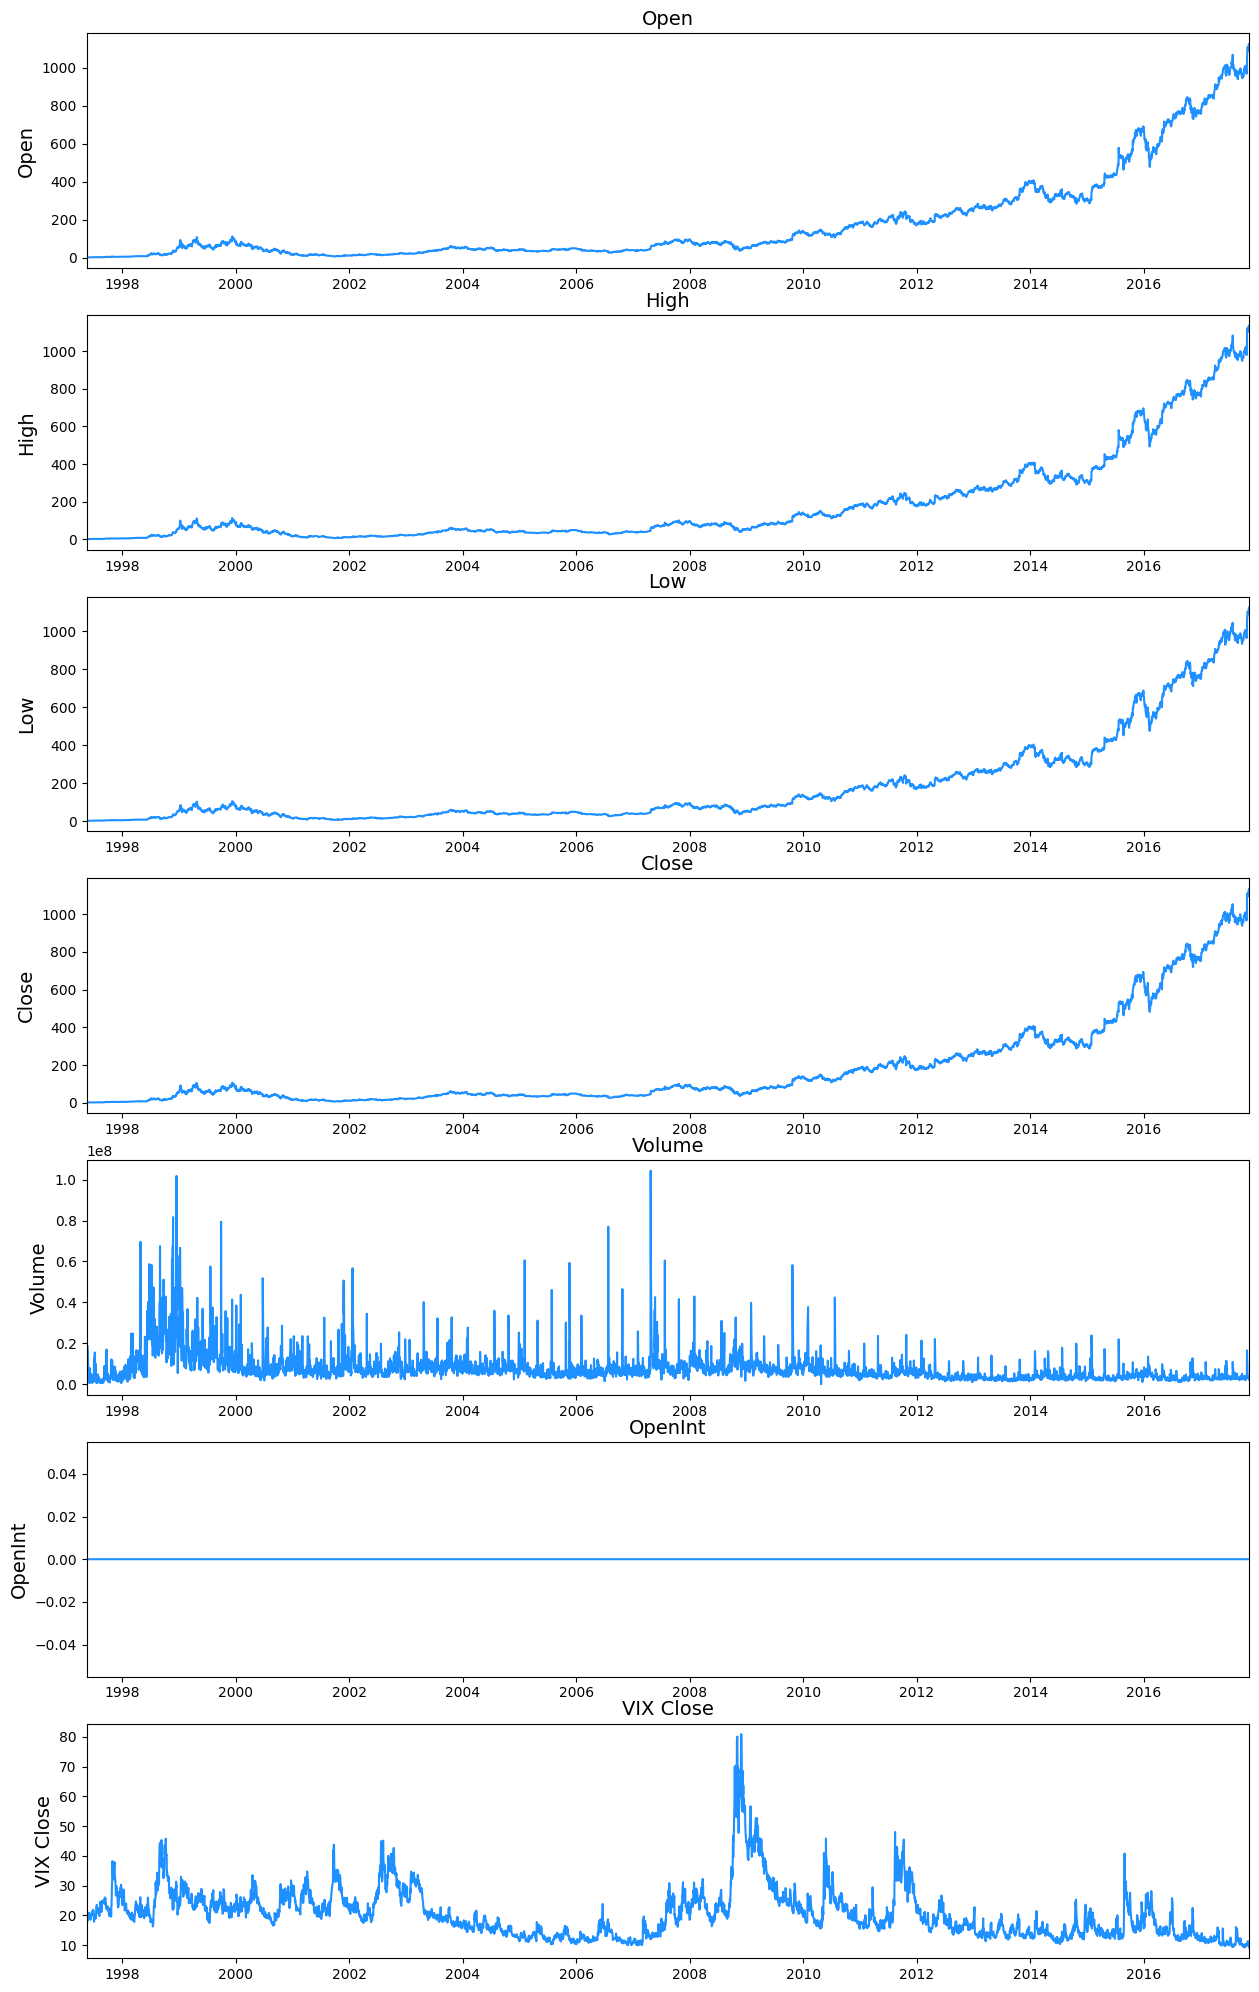

In [669]:
import seaborn as sns 
from datetime import datetime, date 

#plotting the data
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('{}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlabel('')
                      
    ax[i].set_xlim([date(1997, 5, 16), date(2017, 11, 9)])      

Some comments on the patterns visible. 

# Decomposition 

In [670]:
# Split data into training and test sets
train = df.iloc[:5081,:]
test = df.iloc[5081:,:]

### Isolating Trend

<AxesSubplot:>

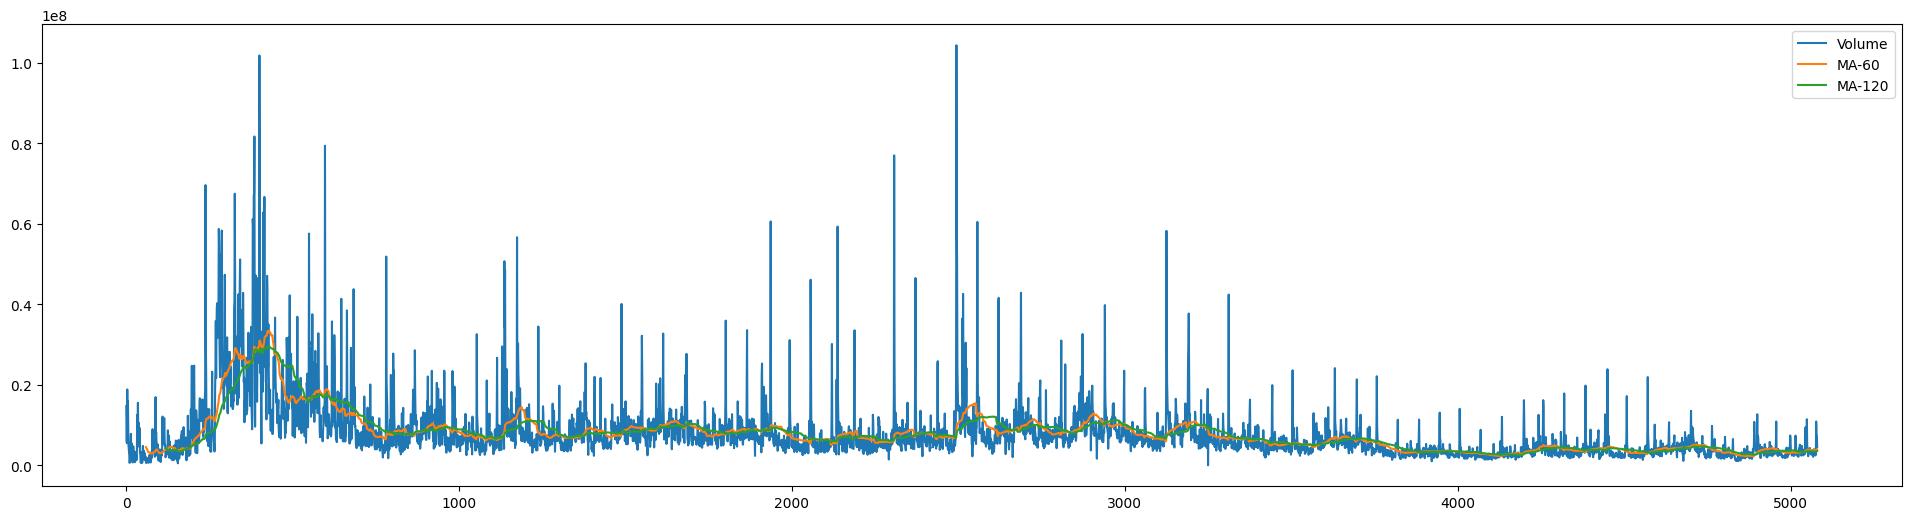

In [671]:
# There are 5 observations per week
train['MA-60'] = train['Volume'].rolling(60).mean()
train['MA-120'] = train['Volume'].rolling(120).mean()

train[['Volume','MA-60','MA-120']].plot(figsize=(24,6))

The MA-120 appears to be too long. You can determine this by observings the effect big changes have on it and how it appears to 'lag' a little more then MA-60.


### De-trending

<AxesSubplot:>

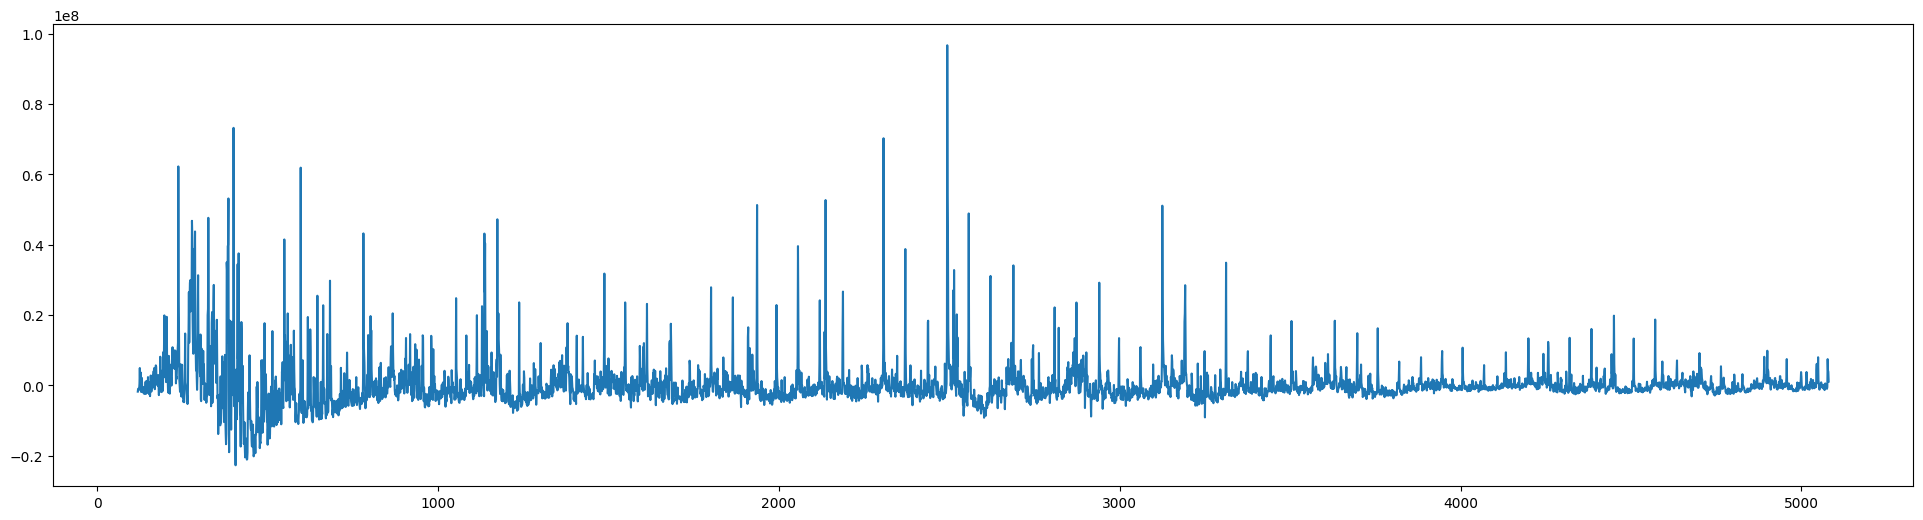

In [672]:
train['vol-detrended'] = train['Volume'] - train['MA-120']
train['vol-detrended'].plot(figsize=(24,6))

### Seasonality Component 

<AxesSubplot:>

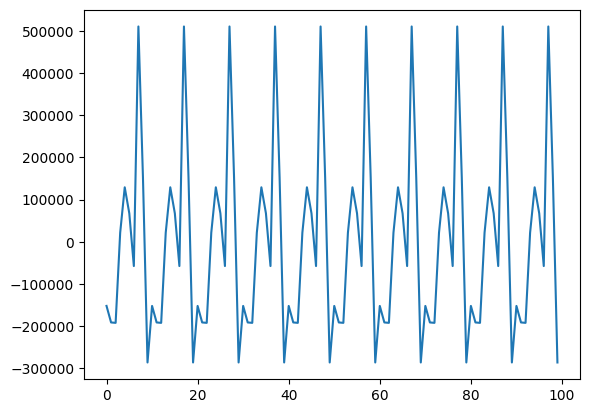

In [673]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train['Volume'], model='additive',period=10)

train['vol-seasonal'] = result._seasonal
result._seasonal[:100].plot()

### Residual

<AxesSubplot:>

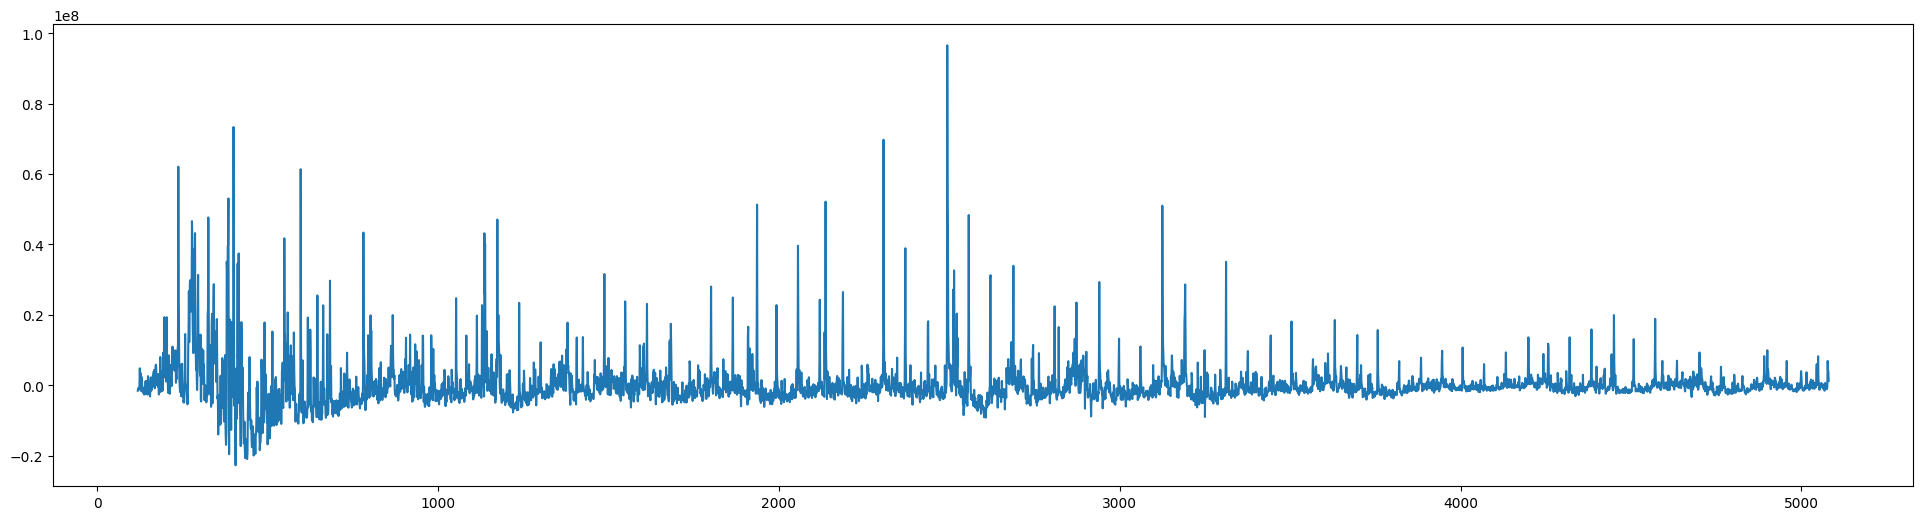

In [674]:
train['vol-residual'] = train['vol-detrended'] - train['vol-seasonal']
train['vol-residual'].plot(figsize=(24,6))

### Manual Decomposition Results


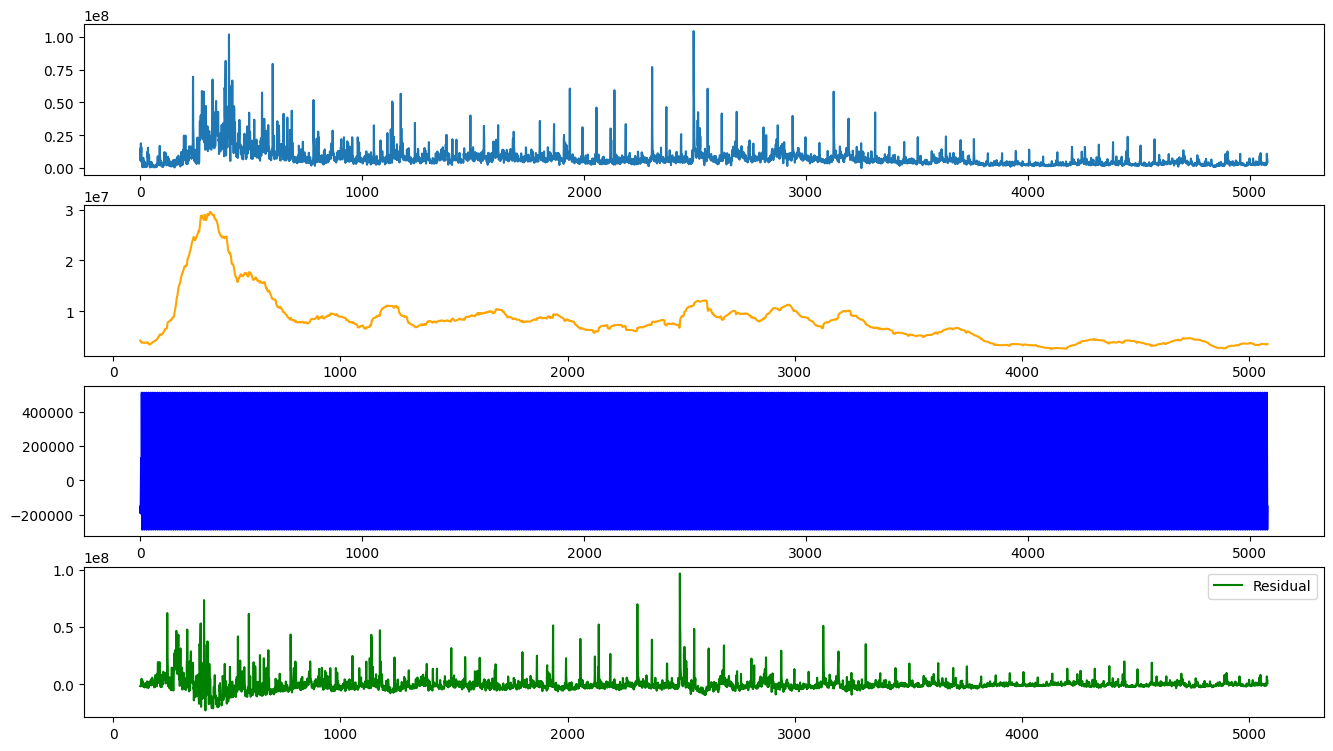

In [675]:
import matplotlib.pyplot as plt
fig, ax_str = plt.subplots(4)
train['Volume'].plot(label='Original', ax=ax_str[0])
train['MA-120'].plot(color='orange', label='MA-120 Trend', ax=ax_str[1])
train['vol-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
train['vol-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

### Automatic Decomposition  

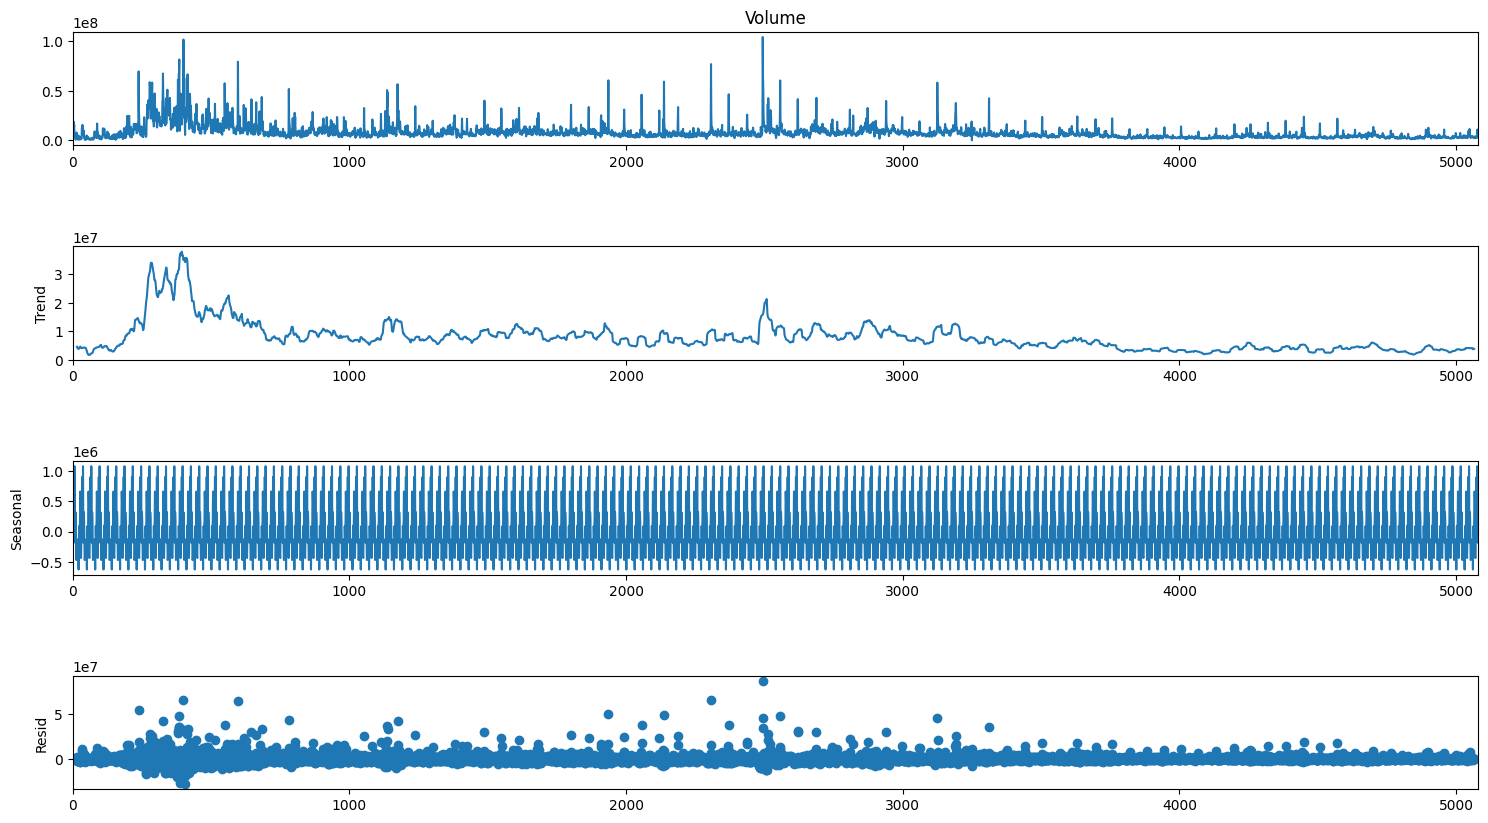

In [676]:
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(train['Volume'],period = 30)
fig = str_res.plot()
fig.set_size_inches((16, 9))

Some comments on the manual vs automatic. 

### Formate the data for models

In [693]:
df.drop('OpenInt', axis=1) # OpenInt is a constant column

#Overite the original dataframe with the automatic decomposition
str_res = seasonal_decompose(df['Volume'],period = 30)

data = str_res.observed.to_frame()
data['seasonal'] = str_res.seasonal
data['trend']=str_res.trend
data['res']=str_res.resid
data['obs']=str_res.observed

train = data.iloc[:5081,:]
test = data.iloc[5081:,:]

# ARIMA Model

### Stationarity?

Data needs to be stationary for ARIMA to be accurate. This means that it is:
- has a constant variance 
- patternless over time 
- roughly horizontal 

<AxesSubplot:>

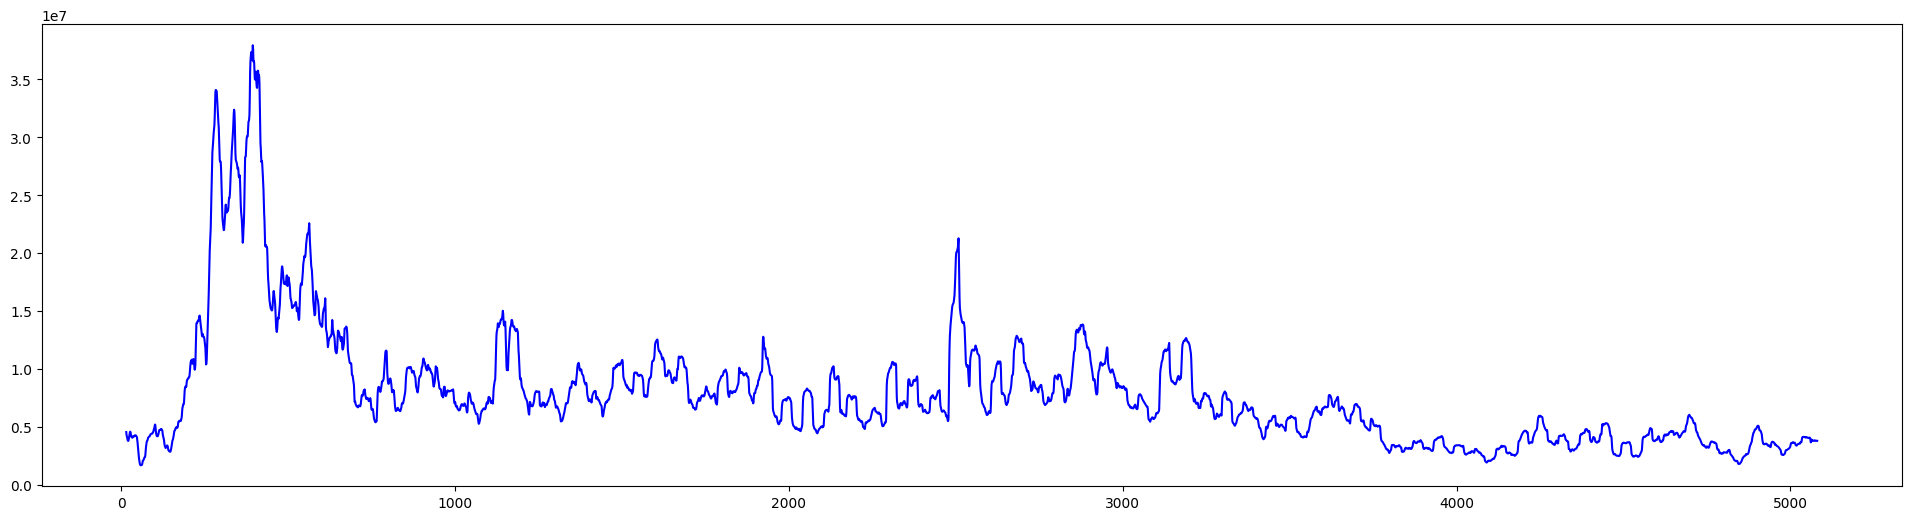

In [704]:
m_data =train['trend']
m_data.plot(color='blue', figsize=(24,6))

### Fit Model

In [ ]:
# Some tools 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

#### Autocorrelations? 

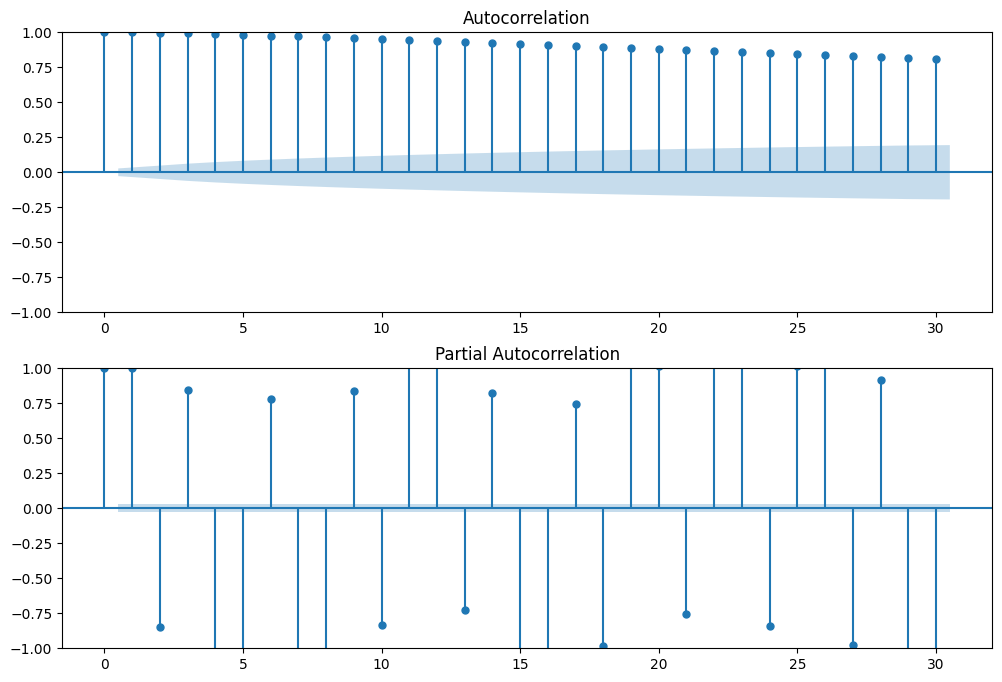

In [714]:
m_data = m_data.dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(m_data, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(m_data, lags=30, ax=ax2)

### Fit Model

In [705]:
arima_1_0_0 = ARIMA(train['trend'], order=(1, 0, 0)).fit()
print(arima_1_0_0.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 5081
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -70138.339
Date:                Tue, 01 Nov 2022   AIC                         140282.678
Time:                        16:59:26   BIC                         140302.278
Sample:                             0   HQIC                        140289.542
                               - 5081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.904e+06   1.86e-14   4.24e+20      0.000     7.9e+06     7.9e+06
ar.L1          0.9989      0.000   3349.633      0.000       0.998       0.999
sigma2      6.203e+10   6.02e-18   1.03e+28      0.0

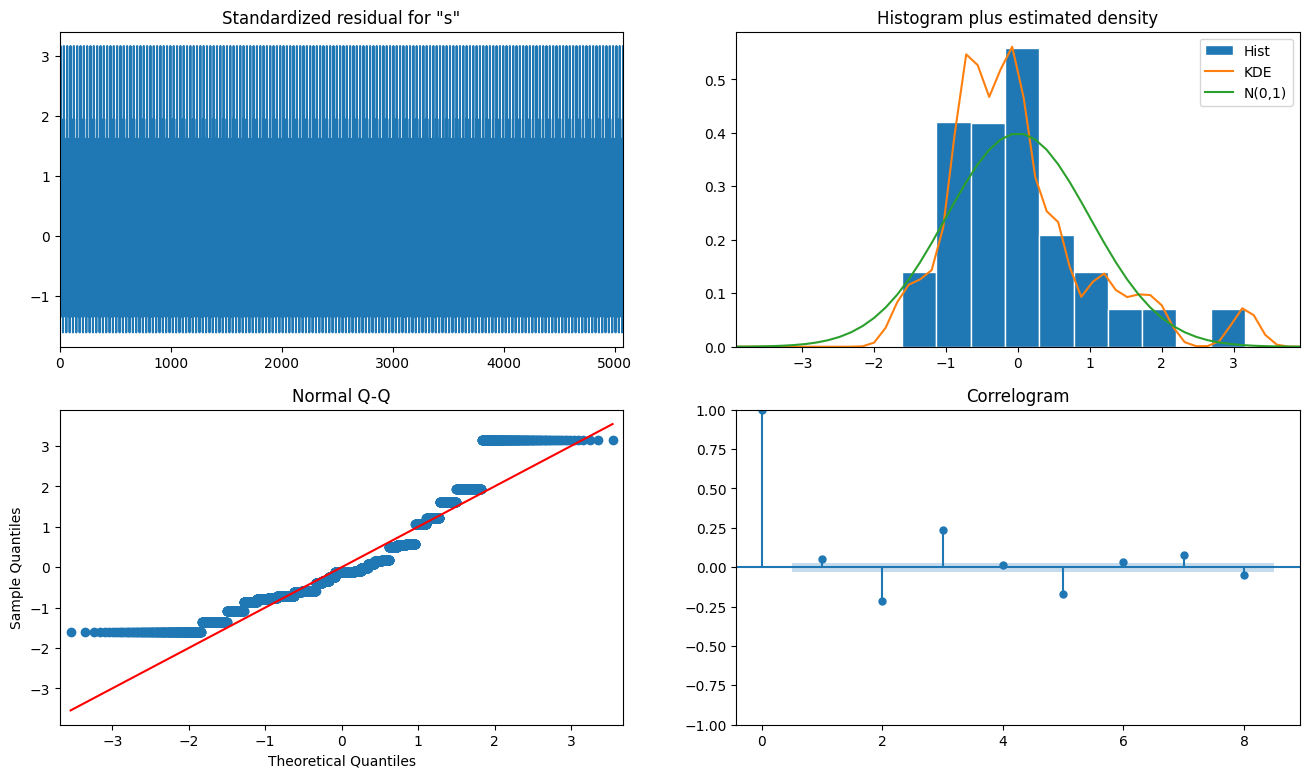

In [700]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_0_0.plot_diagnostics(fig=fig, lags=8)

In [706]:
arima_2_0_1 = ARIMA(train['trend'], order=(2, 0, 1)).fit()
print(arima_2_0_1.summary())


                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                 5081
Model:                 ARIMA(2, 0, 1)   Log Likelihood              -66606.840
Date:                Tue, 01 Nov 2022   AIC                         133223.680
Time:                        16:59:33   BIC                         133256.346
Sample:                             0   HQIC                        133235.120
                               - 5081                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.904e+06   5.08e-12   1.56e+18      0.000     7.9e+06     7.9e+06
ar.L1          1.5348      0.009    163.065      0.000       1.516       1.553
ar.L2         -0.5371      0.009    -56.813      0.0

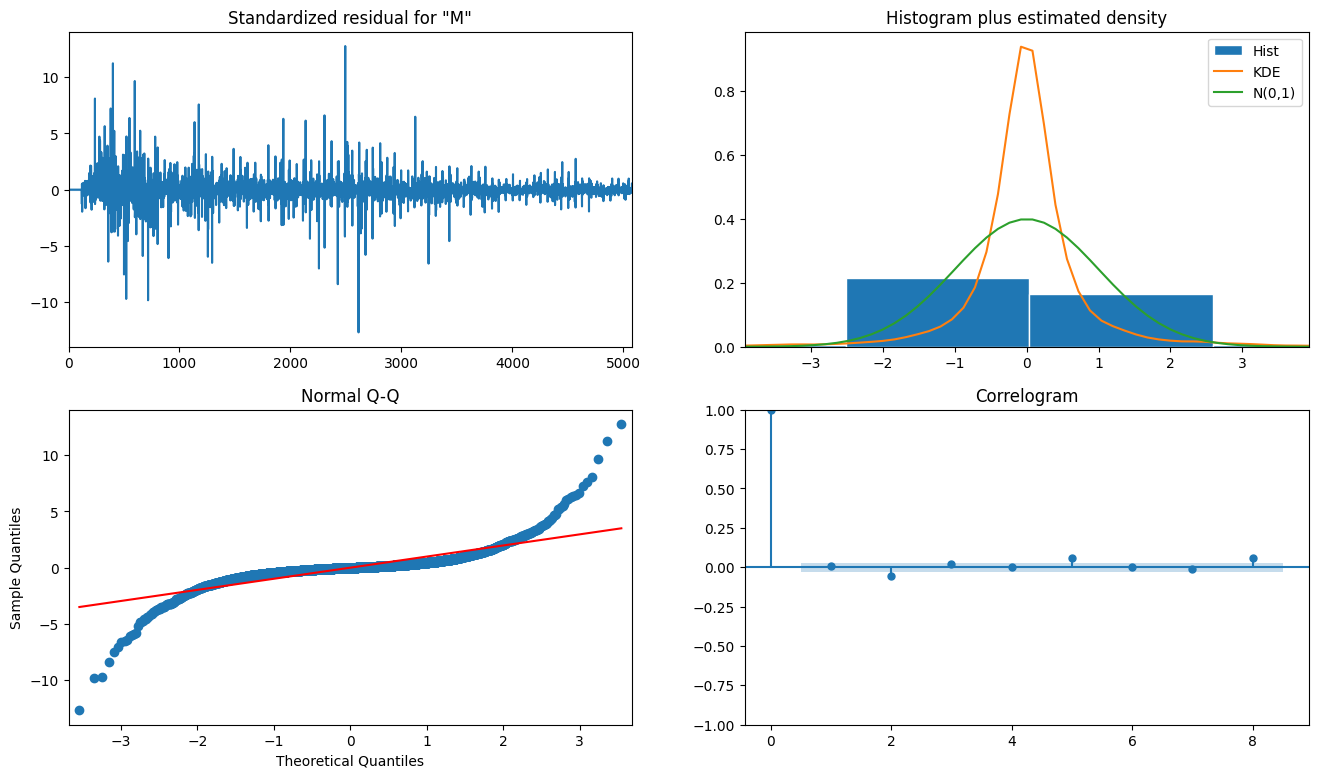

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_0_1.plot_diagnostics(fig=fig, lags=8)

Some comments about goodness of fit. 

### Forcast with ARIMA

In [ ]:
arima_fcst = arima_2_0_1.get_forecast(steps=11)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

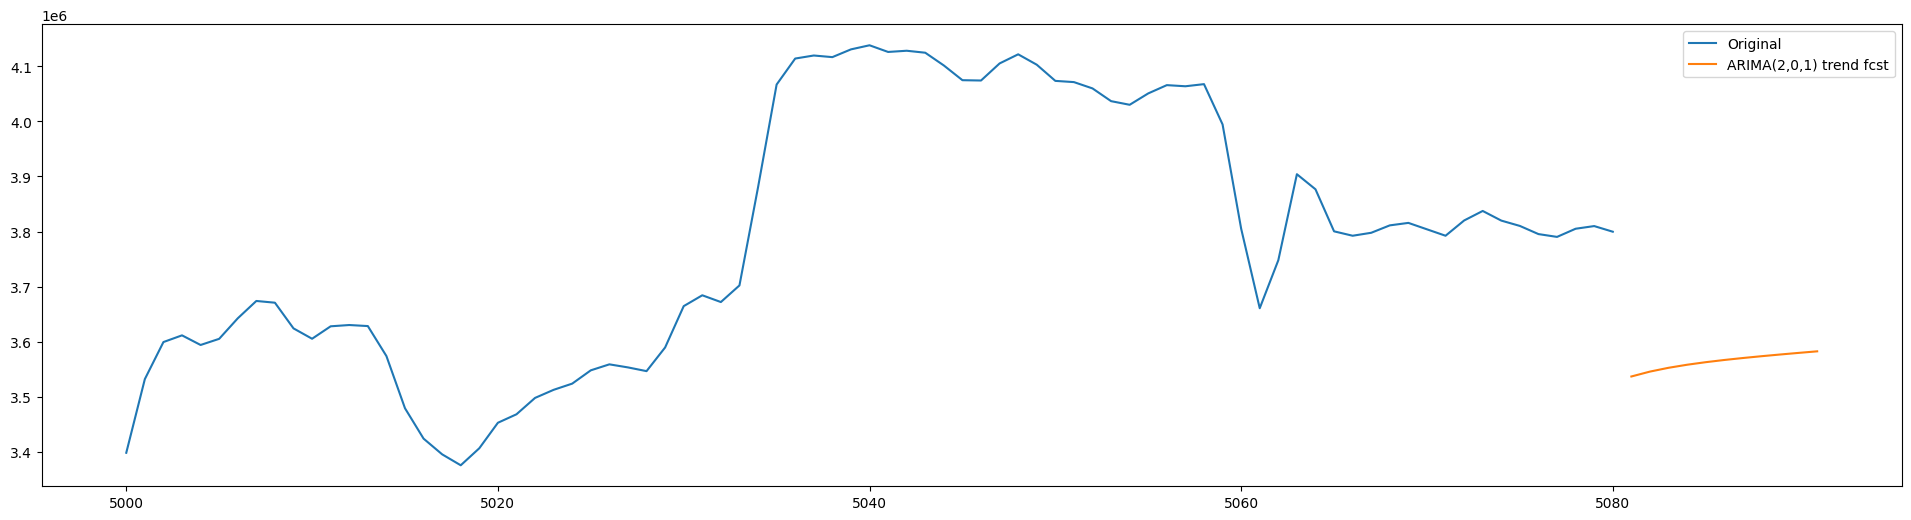

In [707]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train['trend'][5000:].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,0,1) trend fcst", ax=ax_arima_fcst)
plt.legend()


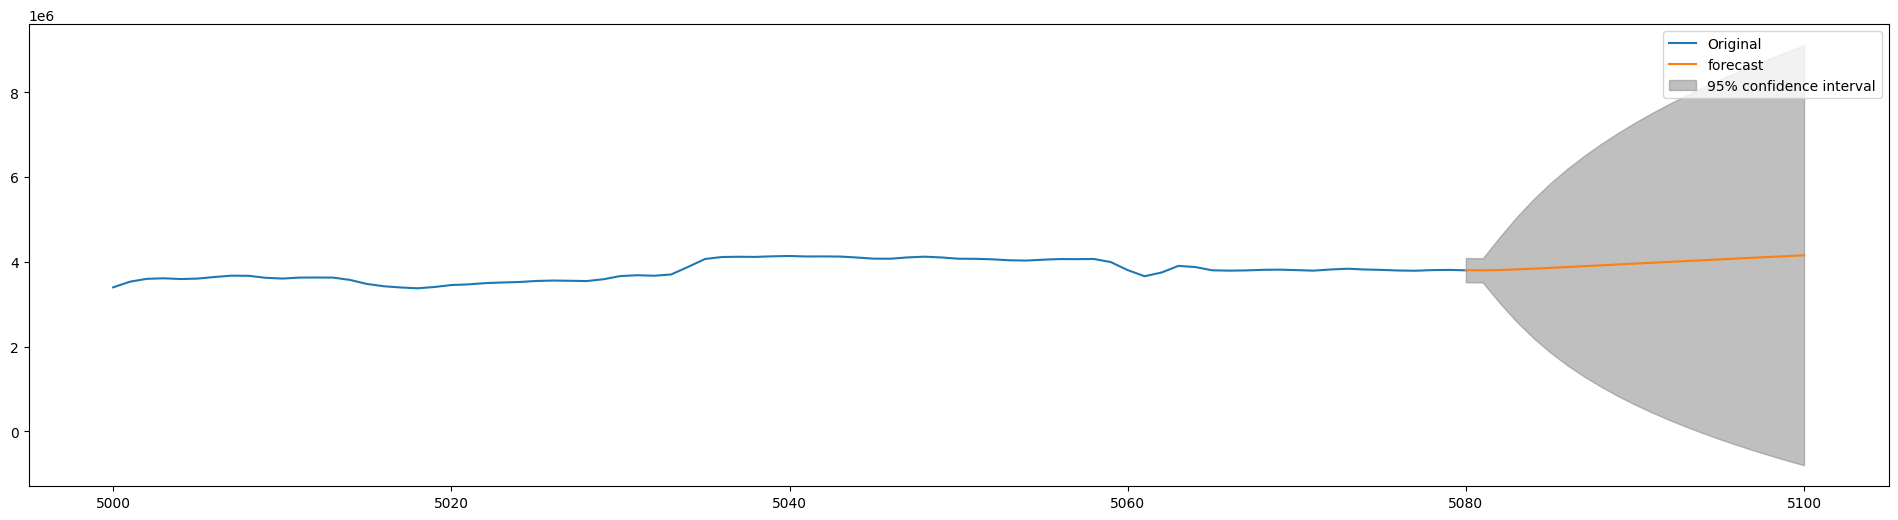

In [710]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train['trend'][5000:].plot(label='Original', ax=ax_arima_fcst)
fig = plot_predict(arima_2_0_1, start = 5080, end= 5100, label='ARIMA(2,0,1) Forecast', ax=ax_arima_fcst)

# Pure Forecaster

A pure forcaster is one that is univariate ie the model takes time and volume exclusivly. This is in comparrison to univariate models which may consider exogenous variables. 

In [761]:
#Create train set
X_train = np.array(range(0,len(train)))
y_train = train['Volume']

# Create test set
X_test = np.array(range(len(train),len(train)+len(test)))
y_test = test['Volume']

In [758]:
from tensorflow import keras

In [764]:
# Create model that will forcast the trend
def create_model(X_train):
    model = keras.Sequential()
    model.add(keras.layers.Dense(1, input_shape=(1,)))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

#train model
model = create_model(X_train)



In [766]:
history = model.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
159/159 [==============================] - 0s 2ms/step - loss: 114634119970816.0000
Epoch 2/100
159/159 [==============================] - 0s 2ms/step - loss: 114502594985984.0000
Epoch 3/100
159/159 [==============================] - 0s 1ms/step - loss: 114369912373248.0000
Epoch 4/100
159/159 [==============================] - 0s 2ms/step - loss: 114236424454144.0000
Epoch 5/100
159/159 [==============================] - 0s 1ms/step - loss: 114101829238784.0000
Epoch 6/100
159/159 [==============================] - 0s 2ms/step - loss: 113966470660096.0000
Epoch 7/100
159/159 [==============================] - 0s 2ms/step - loss: 113829962842112.0000
Epoch 8/100
159/159 [==============================] - 0s 2ms/step - loss: 113692557443072.0000
Epoch 9/100
159/159 [==============================] - 0s 2ms/step - loss: 113554380292096.0000
Epoch 10/100
159/159 [==============================] - 0s 1ms/step - loss: 113415230062592.0000
Epoch 11/100
159/159 [=================

In [778]:
predictions = model.predict(X_test)
result = [pd.Series(predictions[:,0], index=test.index), pd.Series(y_test, index=test.index)]
data = pd.DataFrame


3/3 [==============================] - 0s 2ms/step


numpy.ndarray

KeyError: 'Volume'

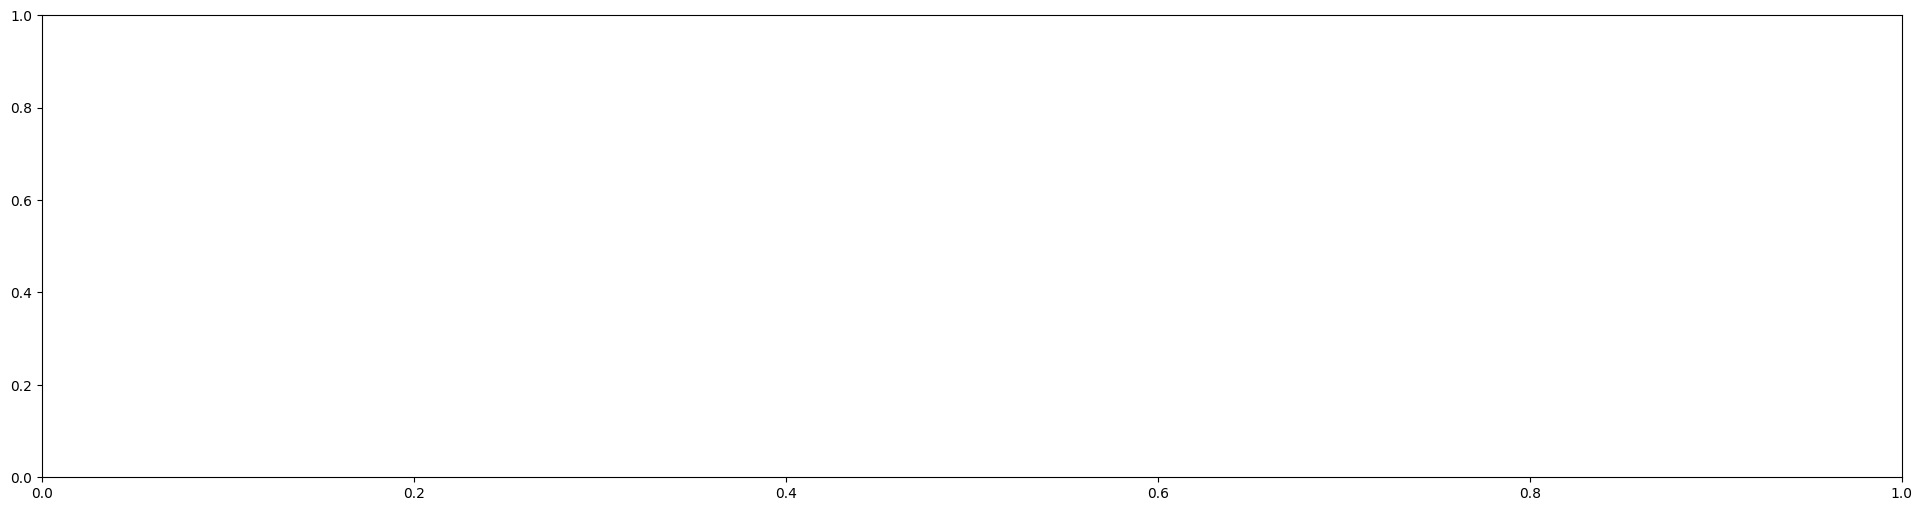

In [775]:
def graph_predictions(y_test):
    fig, ax = plt.subplots(figsize=(24,6))
    y_test['Volume'].plot(label='Original', ax=ax)
    y_test['predictions'].plot(label='Predictions', ax=ax)
    plt.legend()
    plt.show()

graph_predictions(y_test)